In [2]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.5/273.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [12]:
!pip install torch pytorch-forecasting


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 18.7 MB/s eta 0:00:00


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import DistributionLoss


In [51]:
df = pd.read_csv('/content/train.csv', parse_dates=['date'])
df.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [52]:
!pip install optuna

In [53]:
!pip install pytorch-lightning


In [54]:
df["country"].unique()

array(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], dtype=object)

In [55]:
df["store"].unique()

array(['Kaggle Learn', 'Kaggle Store', 'Kagglazon'], dtype=object)

In [56]:
df = df.drop('id', axis = 1)

In [57]:
argentina_df = df[df["country"] == "Argentina"].drop('country', axis = 1)

In [58]:
argentina_kaggle_learn = argentina_df[argentina_df["store"] == "Kaggle Learn"].drop('store', axis = 1)

In [59]:
argentina_kaggle_learn = argentina_kaggle_learn.rename(columns={'date': 'ds', 'product': 'unique_id', 'num_sold': 'y'})

In [60]:
from sklearn.metrics import mean_absolute_error
import optuna

def objective(trial,train, valid, h):

    input_size = trial.suggest_int('input_size', 1, 60)

    n_blocks_season = trial.suggest_int('n_blocks_season', 1, 3)
    n_blocks_trend = trial.suggest_int('n_blocks_trend', 1, 3)
    n_blocks_identity = trial.suggest_int('n_blocks_ident', 1, 3)

    mlp_units_n = trial.suggest_categorical('mlp_units', [32, 64, 128])
    num_hidden = trial.suggest_int('num_hidden', 1, 3)

    n_harmonics = trial.suggest_int('n_harmonics', 1, 5)
    n_polynomials = trial.suggest_int('n_polynomials', 1, 5)

    scaler_type = trial.suggest_categorical('scaler_type', ['standard', 'robust'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


    n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
    mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
    models = [NBEATS(h=h,input_size=input_size,
                 loss=DistributionLoss(distribution='Poisson', level=[90]),
                 max_steps=100,
                 stack_types=['seasonality', 'trend', 'identity'],
                 mlp_units=mlp_units,
                 n_blocks=n_blocks,
                 learning_rate=learning_rate,
                 n_harmonics=n_harmonics,
                 n_polynomials=n_polynomials,
                 scaler_type=scaler_type)
                 ]
    model = NeuralForecast(models=models, freq='D')
    model.fit(train)

    p = model.predict(futr_df=valid).reset_index()
    p = p.merge(valid[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

    loss = mean_absolute_error(p['y'], p['NBEATS'])

    return loss

In [61]:
def form_param_dict(params):
    param_dict = params

    n_blocks_season = param_dict["n_blocks_season"]
    n_blocks_trend = param_dict["n_blocks_trend"]
    n_blocks_identity = param_dict["n_blocks_ident"]

    param_dict["n_blocks"] = [n_blocks_season, n_blocks_trend, n_blocks_identity]

    mlp_units_n = param_dict["mlp_units"]
    num_hidden = param_dict["num_hidden"]
    param_dict["mlp_units"] = [[mlp_units_n, mlp_units_n]]*num_hidden

    param_dict["stack_types"] = ['seasonality', 'trend', 'identity']

    param_dict.pop('n_blocks_season')
    param_dict.pop('n_blocks_trend')
    param_dict.pop('n_blocks_ident')
    param_dict.pop('num_hidden')

    return param_dict

In [62]:
def train_valid(df, threshold):

    train = df[:threshold]
    valid = df[threshold:]
    h = valid['ds'].nunique()

    return train, valid, h

In [63]:
def modelling_process(df, threshold):
    train, valid, h = train_valid(df, threshold)
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, train, valid, h), n_trials=30)

    param_dict = form_param_dict(study.best_params)

    param_dict["h"] = valid['ds'].nunique()

    models = [NBEATS(**param_dict)]

    model = NeuralForecast(models=models, freq='D')
    model.fit(train)

    p = model.predict(futr_df=valid).reset_index()
    p = p.merge(valid[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'],how='left')

    return p

In [64]:
argentina_df.head()

,date,store,product,num_sold
0,2017-01-01,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Kaggle Learn,Using LLMs to Write Better,49


In [65]:
argentina_kaggle_learn

,ds,unique_id,y
0,2017-01-01,Using LLMs to Improve Your Coding,63
1,2017-01-01,Using LLMs to Train More LLMs,66
2,2017-01-01,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Using LLMs to Write Better,49
...,...,...,...
136875,2021-12-31,Using LLMs to Improve Your Coding,44
136876,2021-12-31,Using LLMs to Train More LLMs,47
136877,2021-12-31,Using LLMs to Win Friends and Influence People,6
136878,2021-12-31,Using LLMs to Win More Kaggle Competitions,43


In [66]:
predictions_argentina_kaggle_learn = modelling_process(argentina_kaggle_learn, 9000)

[I 2024-11-11 12:22:13,777] A new study created in memory with name: no-name-bc2a20a9-4eab-48c8-b809-6b833e6e132e
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:22:29,475] Trial 0 finished with value: 25.00769230769231 and parameters: {'input_size': 53, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.05313926495651818}. Best is trial 0 with value: 25.00769230769231.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:22:35,928] Trial 1 finished with value: 3.7539692695324236 and parameters: {'input_size': 46, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 7.654136990391186e-05}. Best is trial 1 with value: 3.7539692695324236.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:22:44,248] Trial 2 finished with value: 25.00769230769231 and parameters: {'input_size': 45, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'robust', 'learning_rate': 0.02035666195078954}. Best is trial 1 with value: 3.7539692695324236.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:22:50,999] Trial 3 finished with value: 3.9426538430727445 and parameters: {'input_size': 24, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 4, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.02492206054353622}. Best is trial 1 with value: 3.7539692695324236.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:22:56,258] Trial 4 finished with value: 3.744399914374718 and parameters: {'input_size': 7, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.00010837588194157423}. Best is trial 4 with value: 3.744399914374718.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:23:04,324] Trial 5 finished with value: 3.163338470458984 and parameters: {'input_size': 29, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.0030131354286107785}. Best is trial 5 with value: 3.163338470458984.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:23:10,499] Trial 6 finished with value: 3.145915368887094 and parameters: {'input_size': 33, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0034067788192368924}. Best is trial 6 with value: 3.145915368887094.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:23:17,331] Trial 7 finished with value: 3.6292460404909574 and parameters: {'input_size': 4, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 5, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.0002309480753905387}. Best is trial 6 with value: 3.145915368887094.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:23:22,503] Trial 8 finished with value: 3.25566155727093 and parameters: {'input_size': 22, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 1, 'n_harmonics': 5, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.00841915202734515}. Best is trial 6 with value: 3.145915368887094.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:23:27,892] Trial 9 finished with value: 3.7263691663742065 and parameters: {'input_size': 20, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 5, 'n_polynomials': 4, 'scaler_type': 'robust', 'learning_rate': 0.00015793392296052322}. Best is trial 6 with value: 3.145915368887094.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:23:34,416] Trial 10 finished with value: 3.1717539163736195 and parameters: {'input_size': 39, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 4, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.0012142919004717624}. Best is trial 6 with value: 3.145915368887094.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:23:40,101] Trial 11 finished with value: 3.114823009417607 and parameters: {'input_size': 34, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 3, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.002247340824406376}. Best is trial 11 with value: 3.114823009417607.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:23:49,378] Trial 12 finished with value: 3.1213230756612926 and parameters: {'input_size': 36, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0007739318956952449}. Best is trial 11 with value: 3.114823009417607.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:23:55,994] Trial 13 finished with value: 3.941653948563796 and parameters: {'input_size': 60, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 2.031181033635473e-05}. Best is trial 11 with value: 3.114823009417607.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:24:05,489] Trial 14 finished with value: 3.2105692349947414 and parameters: {'input_size': 35, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0005738240176345608}. Best is trial 11 with value: 3.114823009417607.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:24:12,144] Trial 15 finished with value: 3.242215497677143 and parameters: {'input_size': 13, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 3, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.0009209363359154081}. Best is trial 11 with value: 3.114823009417607.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:24:20,411] Trial 16 finished with value: 3.011369221027081 and parameters: {'input_size': 42, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.003558002076865096}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:24:27,802] Trial 17 finished with value: 3.087384653091431 and parameters: {'input_size': 42, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.0036851288859960298}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:24:37,851] Trial 18 finished with value: 3.0490923441373385 and parameters: {'input_size': 46, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.008502699521538974}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:24:50,363] Trial 19 finished with value: 3.0888692544056817 and parameters: {'input_size': 51, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.0101941260971787}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:24:57,952] Trial 20 finished with value: 4.253115393565252 and parameters: {'input_size': 54, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.06818728945581401}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:25:05,410] Trial 21 finished with value: 3.020692311800443 and parameters: {'input_size': 42, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.007422485475772737}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:25:11,997] Trial 22 finished with value: 3.0771691945882944 and parameters: {'input_size': 48, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.009475482003888883}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:25:20,559] Trial 23 finished with value: 3.0803538432488073 and parameters: {'input_size': 41, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.021386629959113074}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:25:29,844] Trial 24 finished with value: 3.1112846594590406 and parameters: {'input_size': 58, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.005057421040945275}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:25:35,783] Trial 25 finished with value: 3.326315406652597 and parameters: {'input_size': 28, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.0016207263890523516}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:25:43,202] Trial 26 finished with value: 3.46193084533398 and parameters: {'input_size': 49, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.0004179291556045681}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:25:51,438] Trial 27 finished with value: 3.0338922097132754 and parameters: {'input_size': 44, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.029988224210029935}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:25:57,422] Trial 28 finished with value: 25.00769230769231 and parameters: {'input_size': 39, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.08193855962766142}. Best is trial 16 with value: 3.011369221027081.
<ipython-input-60-a94e329f50a9>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
INFO:lightning_fabric.utilities.seed:Seed set to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
[I 2024-11-11 12:26:02,973] Trial 29 finished with value: 3.4573076761685884 and parameters: {'input_size': 56, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.036049539728788695}. Best is trial 16 with value: 3.011369221027081.
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pyt

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:210: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [67]:
predictions_argentina_kaggle_learn

,unique_id,ds,NBEATS,y
0,Using LLMs to Improve Your Coding,2021-12-06,28.934710,29
1,Using LLMs to Improve Your Coding,2021-12-07,29.662914,28
2,Using LLMs to Improve Your Coding,2021-12-08,29.488653,29
3,Using LLMs to Improve Your Coding,2021-12-09,29.968897,31
4,Using LLMs to Improve Your Coding,2021-12-10,31.312584,32
...,...,...,...,...
125,Using LLMs to Write Better,2021-12-27,19.925854,28
126,Using LLMs to Write Better,2021-12-28,20.188435,30
127,Using LLMs to Write Better,2021-12-29,20.079933,37
128,Using LLMs to Write Better,2021-12-30,20.209894,34


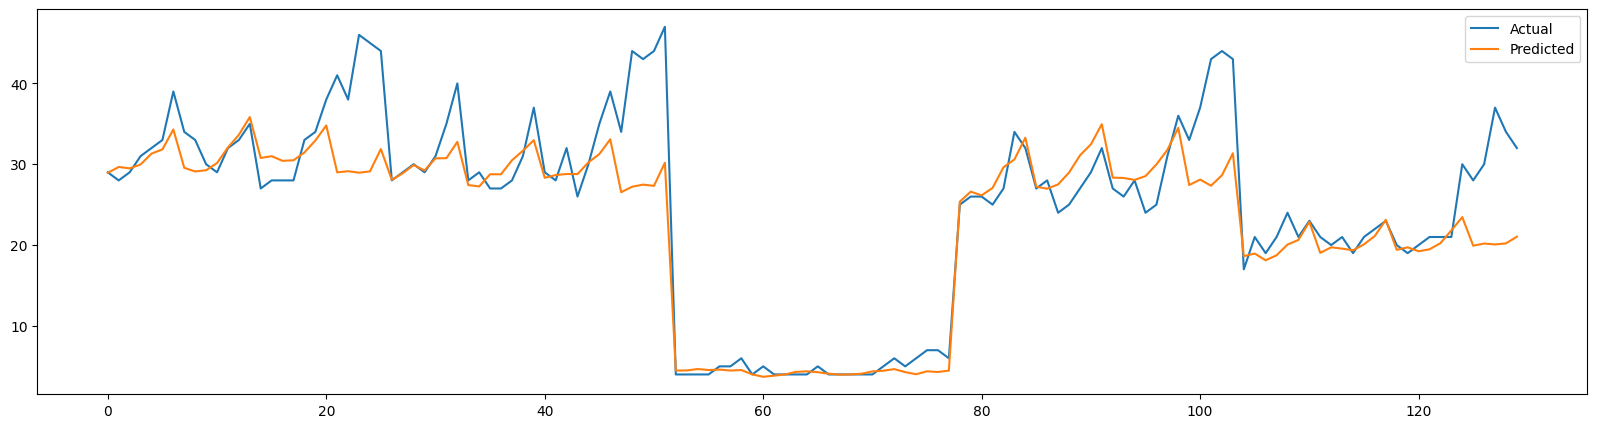

In [68]:
predictions_argentina_kaggle_learn["y"].plot(figsize=(20,5), label = "Actual")
predictions_argentina_kaggle_learn["NBEATS"].plot(label = "Predicted")
plt.legend()

In [69]:
predictions_argentina_kaggle_learn["Residual"] = predictions_argentina_kaggle_learn["y"] - predictions_argentina_kaggle_learn["NBEATS"]

In [70]:
predictions_argentina_kaggle_learn

,unique_id,ds,NBEATS,y,Residual
0,Using LLMs to Improve Your Coding,2021-12-06,28.934710,29,0.065290
1,Using LLMs to Improve Your Coding,2021-12-07,29.662914,28,-1.662914
2,Using LLMs to Improve Your Coding,2021-12-08,29.488653,29,-0.488653
3,Using LLMs to Improve Your Coding,2021-12-09,29.968897,31,1.031103
4,Using LLMs to Improve Your Coding,2021-12-10,31.312584,32,0.687416
...,...,...,...,...,...
125,Using LLMs to Write Better,2021-12-27,19.925854,28,8.074146
126,Using LLMs to Write Better,2021-12-28,20.188435,30,9.811565
127,Using LLMs to Write Better,2021-12-29,20.079933,37,16.920067
128,Using LLMs to Write Better,2021-12-30,20.209894,34,13.790106


In [71]:
predictions_argentina_kaggle_learn["Residual (%)"] = np.abs(((predictions_argentina_kaggle_learn["y"] - predictions_argentina_kaggle_learn["NBEATS"]) / predictions_argentina_kaggle_learn["y"]) * 100)

In [72]:
predictions_argentina_kaggle_learn

,unique_id,ds,NBEATS,y,Residual,Residual (%)
0,Using LLMs to Improve Your Coding,2021-12-06,28.934710,29,0.065290,0.225139
1,Using LLMs to Improve Your Coding,2021-12-07,29.662914,28,-1.662914,5.938980
2,Using LLMs to Improve Your Coding,2021-12-08,29.488653,29,-0.488653,1.685011
3,Using LLMs to Improve Your Coding,2021-12-09,29.968897,31,1.031103,3.326139
4,Using LLMs to Improve Your Coding,2021-12-10,31.312584,32,0.687416,2.148175
...,...,...,...,...,...,...
125,Using LLMs to Write Better,2021-12-27,19.925854,28,8.074146,28.836237
126,Using LLMs to Write Better,2021-12-28,20.188435,30,9.811565,32.705218
127,Using LLMs to Write Better,2021-12-29,20.079933,37,16.920067,45.729910
128,Using LLMs to Write Better,2021-12-30,20.209894,34,13.790106,40.559135


In [73]:
def draw_graphs_by_book(book_name):
    sample_book = argentina_kaggle_learn[argentina_kaggle_learn["unique_id"] == book_name]
    sample_book_prediction = predictions_argentina_kaggle_learn[predictions_argentina_kaggle_learn["unique_id"] == book_name]
    plt.figure(figsize=(20,5))
    plt.title("Book Name: " + book_name)
    sns.lineplot(data = sample_book[1780:], x="ds", y="y", label="Actual")
    sns.lineplot(data=sample_book_prediction, x="ds", y="NBEATS", label="Prediction")
    plt.show()

In [74]:
predictions_argentina_kaggle_learn["unique_id"].unique()

array(['Using LLMs to Improve Your Coding',
       'Using LLMs to Train More LLMs',
       'Using LLMs to Win Friends and Influence People',
       'Using LLMs to Win More Kaggle Competitions',
       'Using LLMs to Write Better'], dtype=object)

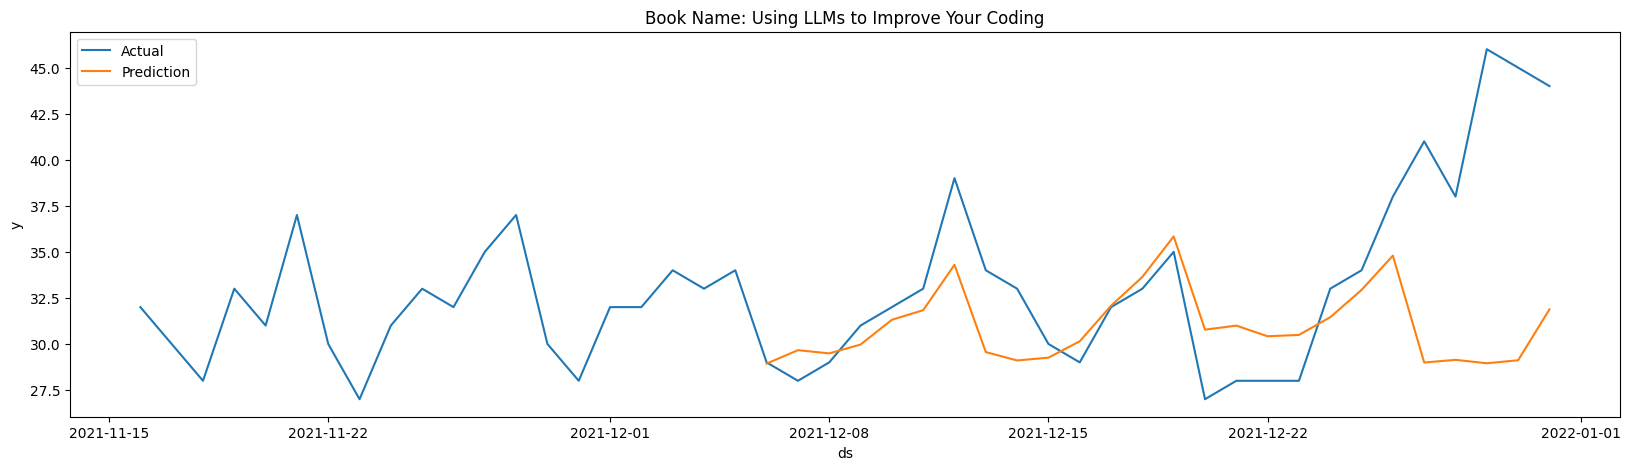

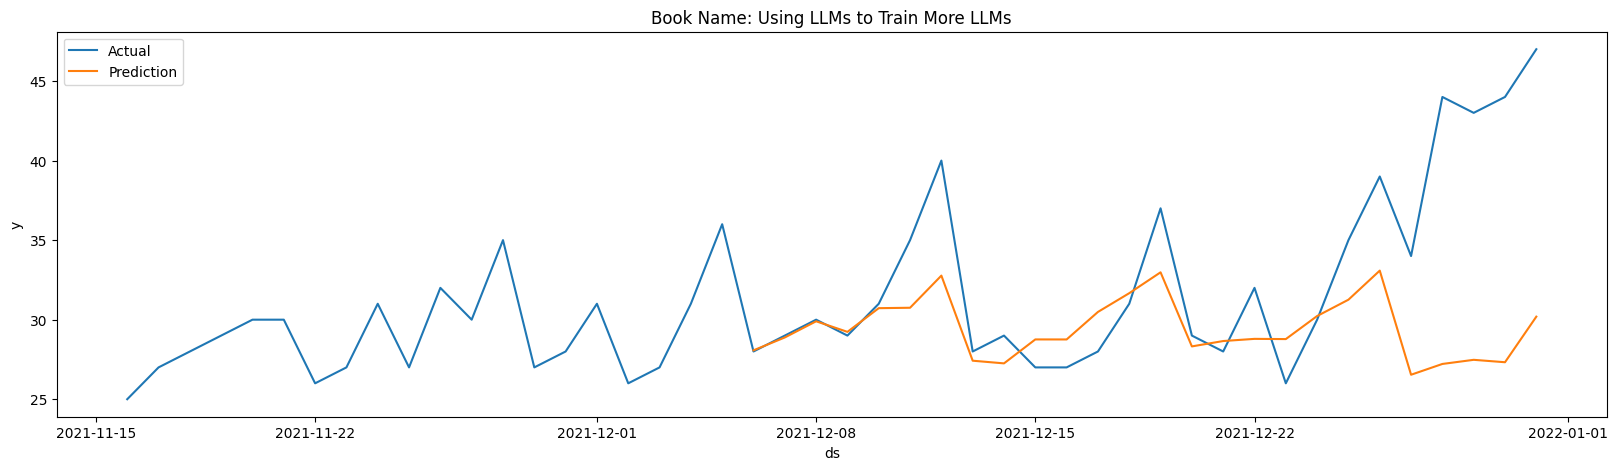

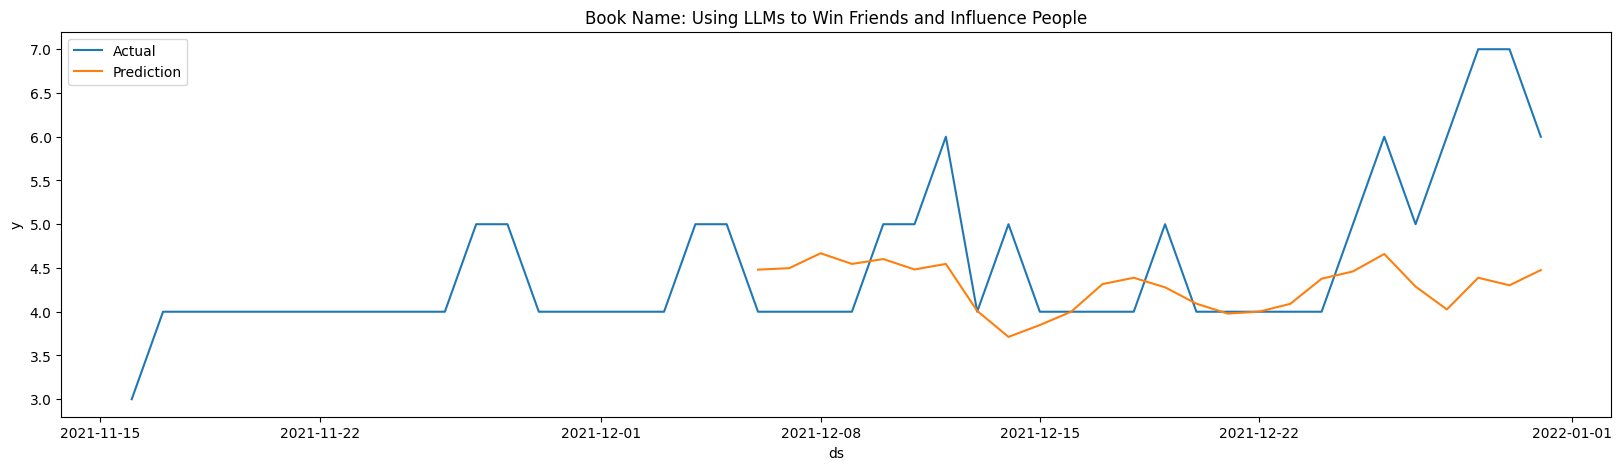

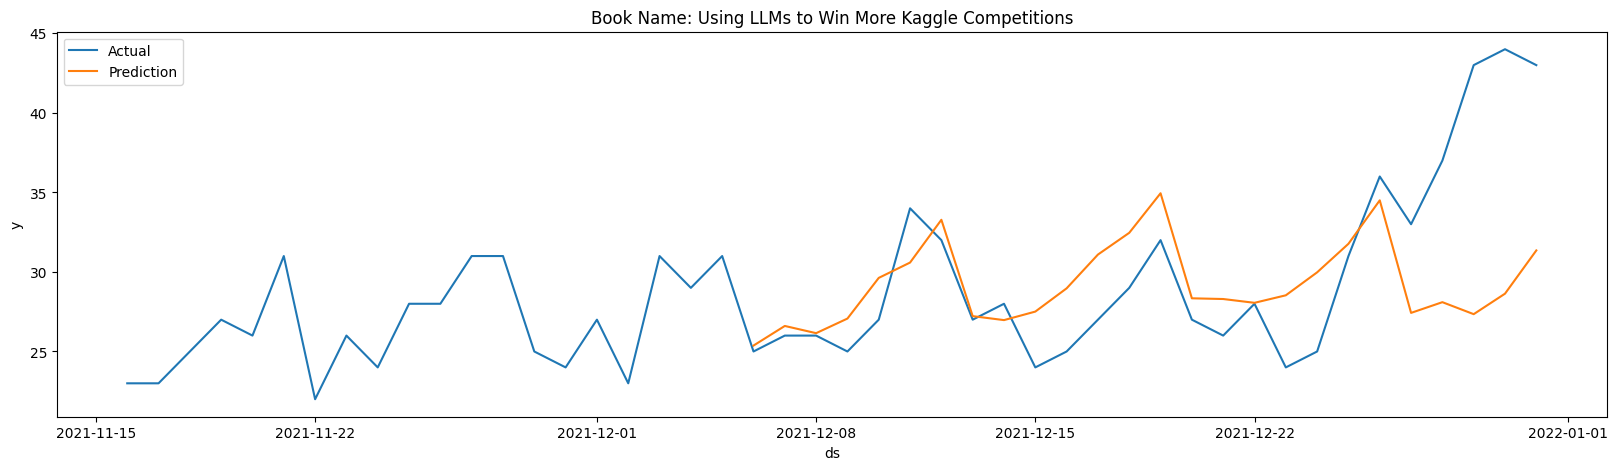

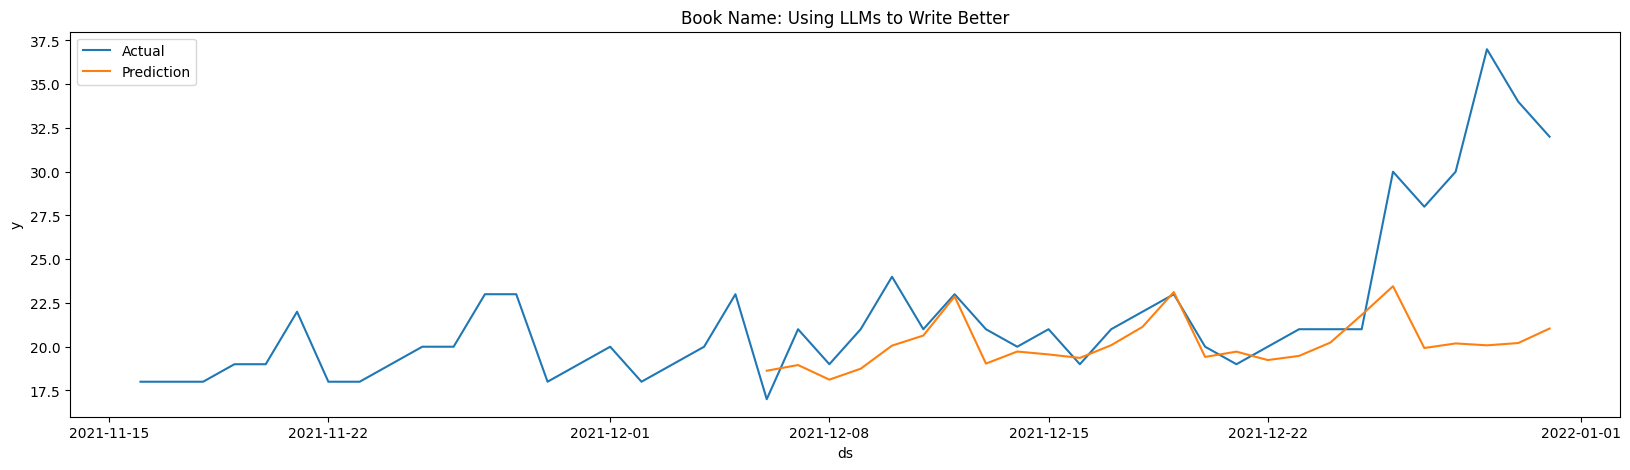

In [75]:
for book in predictions_argentina_kaggle_learn["unique_id"].unique():
    draw_graphs_by_book(book)